# Kural Tabanlı Sınıflandırma ile Potansiyel Müşteri Getirisi Hesaplama

## İş problemi
* Gezinomi(Türkiyede yer alan seyahat planlama platformu) yaptığı satışların bazı özelliklerini kullanarak seviye tabanlı yeni satış tanımları oluşturmak ve bu yeni satış tanımlarına göre segmentler oluşturup bu segmentlere göre yeni gelebilecek müşterilerin şirkete ortalama ne kadar kazandırabileceğini tahmin etmek istemektedir.
    * Örneğin, Antalyada Her şey dahil bir otele yoğun dönemde gitmek isteyen bir müşterinin ortalama ne kadar kazandırabileceği belirlenmek isteniyor.

## Veri Seti Hikayesi
* Veri seti, gezinomi şirketinin yaptığı satışların fiyatlarını ve bu satışlara ait bilgiler içermektedir. Veri seti her satış işleminde oluşan kayıtlardan meydana gelmektedir. Bunun anlamı tablo tekilleştirilmemiştir. Diğer bir ifade ile müşteri birden fazla alışveriş yapmış olabilir.

## Değişkenler
* SaleId : Satış ID
* SaleDate : Satış Tarihi
* CheckInDate : Müşterinin otele giriş tarihi
* Price : Satış için ödenen fiyat
* ConceptName : Otel onsept bilgisi
* SaleCityName : Otelin bulunduğu şehir bilgisi
* CInDay : Müşterinin otele giriş günü
* SaleCheckInDayOff : Check'in ile giriş tarihi gün farkı
* Season : Otele giriş tarihindeki sezon bilgisi

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [3]:
df = pd.read_excel("/gezinomi.xlsx")
df.head()

,SaleId,SaleDate,CheckInDate,Price,ConceptName,SaleCityName,CInDay,SaleCheckInDayDiff,Seasons
0,415122,2022-12-03,2022-12-03,79.304029,Herşey Dahil,Antalya,Saturday,0,Low
1,415103,2022-12-03,2022-12-03,45.970696,Yarım Pansiyon,Antalya,Saturday,0,Low
2,404034,2022-09-12,2022-09-13,77.838828,Herşey Dahil,Antalya,Tuesday,1,High
3,415094,2022-12-03,2022-12-10,222.710623,Yarım Pansiyon,İzmir,Saturday,7,Low
4,414951,2022-12-01,2022-12-03,140.476190,Yarım Pansiyon,İzmir,Saturday,2,Low


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59164 entries, 0 to 59163
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   SaleId              59164 non-null  int64         
 1   SaleDate            59164 non-null  datetime64[ns]
 2   CheckInDate         59164 non-null  datetime64[ns]
 3   Price               59151 non-null  float64       
 4   ConceptName         59164 non-null  object        
 5   SaleCityName        59164 non-null  object        
 6   CInDay              59164 non-null  object        
 7   SaleCheckInDayDiff  59164 non-null  int64         
 8   Seasons             59164 non-null  object        
dtypes: datetime64[ns](2), float64(1), int64(2), object(4)
memory usage: 4.1+ MB


* Veri setimizde toplam 8 değişken bulunmaktadır. Bu değişkenlerin hiçbirinde eksik değer bulunmamaktadır. Veri tipine göre daha detaylı bir inceleme yapalım.

* Bu incelemeleri kategorik ve sayısal değişkenler olarak 2 ayrı şekilde yapacağız. Her zaman kullanabilmek adına fonksiyon şeklinde yazılacaktır.

### 1) Kategorik Değişkenler için genel bir bakış

Observations : 59164
Variables : 9
cat_cols : 4
num_cols : 3
cat_but_car : 0
num_but_cat : 0
                ConceptName      Ratio
ConceptName                           
Herşey Dahil          53186  89.895883
Yarım Pansiyon         3559   6.015482
Oda + Kahvaltı         2419   4.088635
############################################


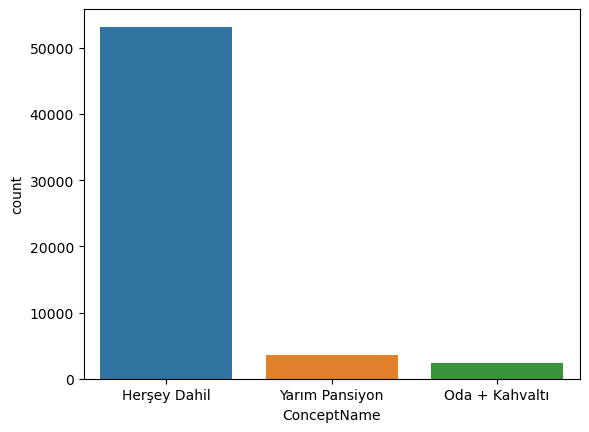

              SaleCityName      Ratio
SaleCityName                         
Antalya              31649  53.493679
Muğla                10662  18.021094
Aydın                10646  17.994050
Diğer                 3245   5.484754
İzmir                 2507   4.237374
Girne                  455   0.769049
############################################


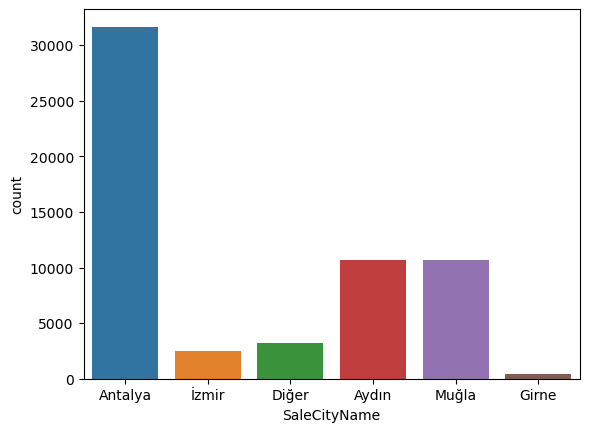

           CInDay      Ratio
CInDay                      
Monday      12794  21.624637
Saturday     9967  16.846393
Friday       8683  14.676154
Thursday     7314  12.362247
Sunday       7050  11.916030
Tuesday      6807  11.505307
Wednesday    6549  11.069231
############################################


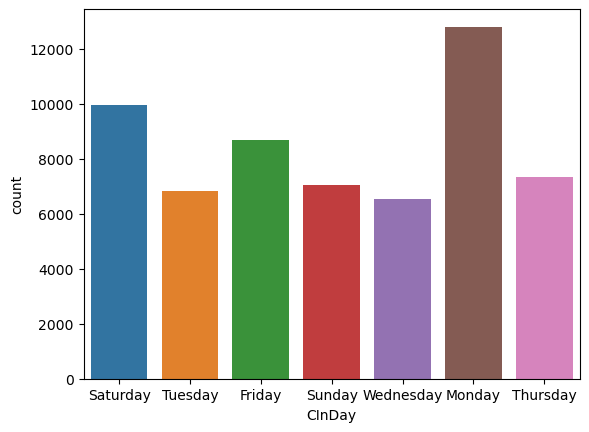

         Seasons      Ratio
Seasons                    
High       50946  86.109796
Low         8218  13.890204
############################################


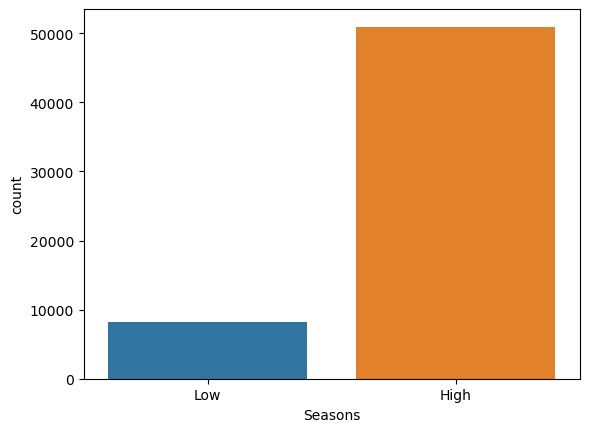

In [5]:
for col in df.columns:
    if df[col].dtypes == "bool":
        df[col] = df[col].astype(int)


def grab_col_names(dataframe):

    cat_cols = [col for col in dataframe.columns if str(df[col].dtypes) in ["category","object","bool"]]
    num_but_cat = [col for col in dataframe.columns if df[col].nunique() < 10 and df[col].dtypes in ["int","float"]]
    cat_cols = cat_cols + num_but_cat
    cat_but_car = [col for col in df.columns if df[col].nunique() > 20 and str (df[col].dtypes) in ["category","object"]]
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    num_cols = [col for col in df.columns if df[col].dtypes in ["int","float"]]
    num_cols = [col for col in num_cols if col not in cat_cols]


    # Basit bir raporlama kısmı ekler isek;
    print(f"Observations : {df.shape[0]}")
    print(f"Variables : {df.shape[1]}")
    print(f"cat_cols : {len(cat_cols)}")
    print(f"num_cols : {len(num_cols)}")
    print(f"cat_but_car : {len(cat_but_car)}")
    print(f"num_but_cat : {len(num_but_cat)}")

    return cat_cols, num_cols, cat_but_car

def cat_summary(dataframe, col_name, plot = False) :
    print(pd.DataFrame({col_name: dataframe[col_name]. value_counts(),
                        "Ratio" : 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("############################################")

    if plot:
        sns.countplot(x = dataframe[col_name], data = dataframe)
        plt.show(block = True)

cat_cols, num_cols, cat_but_car = grab_col_names(df)

for col in cat_cols:
    if df[col].dtypes == "bool" :
        df[col] = df[col].astype(int)
    else :
        cat_summary(df, col, plot = True)

* Konsept olarak bakıldığında,
    * "her şey dahil" satın alınma sayısı, toplam satın alınma sayısının yüzde 89.90'ını oluşturuyor. İkinci tercih edilen konsept "Yarım Pansiyon" fakat aralarında çok fark olduğunu görebiliyoruz. 

* Satın alınmaların meydana geldiği şehirlere baktığımızda,
    * Satın alınmaların yarısından fazlası Antalyada yer almaktadır.
    * Genel olarak bakıldığında, kıyı ve sıcak kesimler daha çok tercih edilmektedir.
    
* Müşterilerin otele giriş günü için,
    * En çok giriş yapılan gün Pazartesi günü. Bunun arkasından Cumartesi ve Cuma gelmektedir.
    * Pazartesi günü hariç diğer günler birbirlerine çok yakın. 
    
* Sezon açısından bakıldığında,
    * Müşteriler en kalabalık sezonu tercih etmişler. 

## 2) Sayısal Değişkenler için genel bir bakış

count     59164.000000
mean     302675.795433
std       87943.222683
min       51707.000000
5%        97069.150000
10%      151668.200000
20%      264091.000000
30%      286159.700000
40%      306032.600000
50%      321607.000000
60%      337027.800000
70%      358812.000000
80%      376121.200000
90%      393616.000000
100%     415122.000000
max      415122.000000
Name: SaleId, dtype: float64


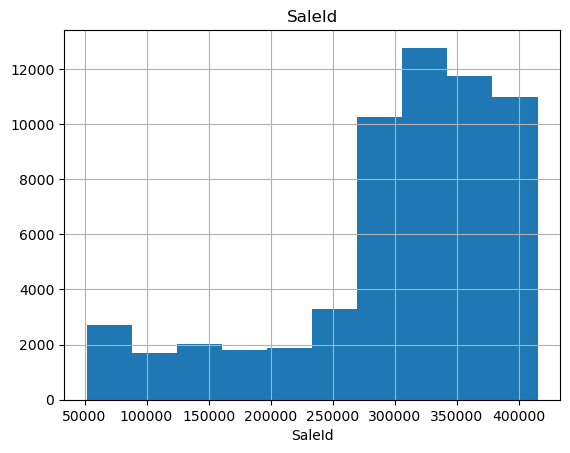

count    59151.000000
mean        61.345057
std         51.384617
min          0.000000
5%          19.640853
10%         24.458104
20%         31.796907
30%         39.169473
40%         46.357616
50%         54.261294
60%         61.868687
70%         72.218260
80%         84.848485
90%        106.301370
100%      4880.471380
max       4880.471380
Name: Price, dtype: float64


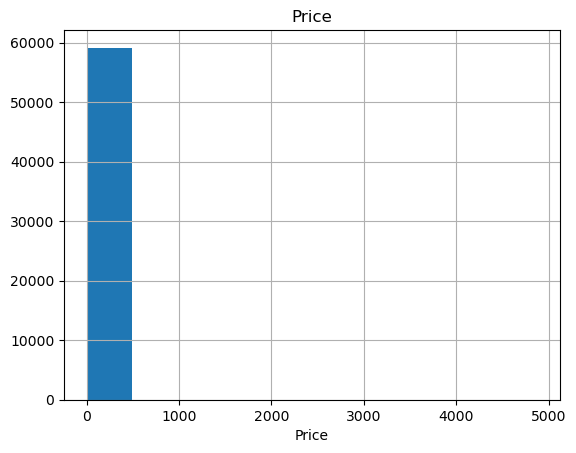

count    59164.000000
mean        31.840173
std         51.493509
min          0.000000
5%           0.000000
10%          1.000000
20%          2.000000
30%          3.000000
40%          6.000000
50%         10.000000
60%         16.000000
70%         26.000000
80%         46.000000
90%        103.000000
100%       630.000000
max        630.000000
Name: SaleCheckInDayDiff, dtype: float64


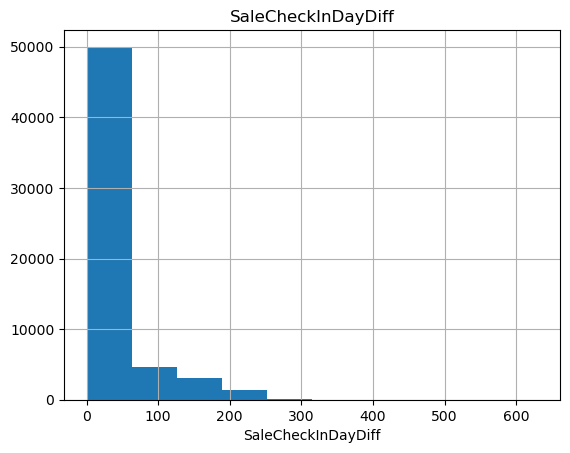

Observations : 59164
Variables : 9
cat_cols : 4
num_cols : 3
cat_but_car : 0
num_but_cat : 0


In [8]:
def num_summary(dataframe, numerical_col, plot = False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 1]
    print (dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist()
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show(block = True)

for col in num_cols:
    num_summary(df, col, plot = True)

cat_cols, num_cols, cat_but_car = grab_col_names(df)

### Şimdi, analizi biraz daha spesifikleştirerek devam edelim. 

#### Şehirlerde gerçekleşen satışlara bir göz atalım

In [11]:
sehir_gerceklesen_satis = df.groupby("SaleCityName").agg({
    "Price": ["sum", "mean"],
    "SaleCityName": ["nunique", "count"]
})

# 'Price' sütunundaki 'sum' değerlerine göre sıralama
sehir_gerceklesen_satis = sehir_gerceklesen_satis.sort_values(by=("Price", "sum"), ascending=False)
print(sehir_gerceklesen_satis)

                     Price            SaleCityName       
                       sum       mean      nunique  count
SaleCityName                                             
Antalya       2.041911e+06  64.521474            1  31649
Muğla         6.658422e+05  62.461746            1  10662
Aydın         5.732960e+05  53.855896            1  10646
İzmir         1.659348e+05  66.267905            1   2507
Diğer         1.545723e+05  47.707497            1   3245
Girne         2.706503e+04  59.483579            1    455


#### Konsepte göre gerçekleşen satışlara bakalım.

In [14]:
concept_gerceklesen_satis = df.groupby("ConceptName").agg({
    "Price" : ["sum","mean"],
    "ConceptName" : ["count","nunique"]})

print(concept_gerceklesen_satis.sort_values(by = ("Price", "sum"),ascending = False))

                       Price            ConceptName        
                         sum       mean       count nunique
ConceptName                                                
Herşey Dahil    3.332911e+06  62.672260       53186       1
Yarım Pansiyon  1.744024e+05  49.030742        3559       1
Oda + Kahvaltı  1.213084e+05  50.252010        2419       1


#### Şehir - Konsept kırılımında fiyat durumuna bakalım.

In [15]:
print(df.groupby(["SaleCityName","ConceptName"]).agg({"Price" : "mean"}))

                                 Price
SaleCityName ConceptName              
Antalya      Herşey Dahil    64.519028
             Oda + Kahvaltı  63.504816
             Yarım Pansiyon  67.190613
Aydın        Herşey Dahil    53.995467
             Oda + Kahvaltı  34.458787
             Yarım Pansiyon  30.016543
Diğer        Herşey Dahil    84.771093
             Oda + Kahvaltı  37.599082
             Yarım Pansiyon  42.113440
Girne        Herşey Dahil    97.680970
             Oda + Kahvaltı  39.775536
             Yarım Pansiyon  53.247838
Muğla        Herşey Dahil    63.020053
             Oda + Kahvaltı  59.037763
             Yarım Pansiyon  45.120924
İzmir        Herşey Dahil    74.701519
             Oda + Kahvaltı  41.320342
             Yarım Pansiyon  59.610053


* Şehir Bazında Fiyat Dağılımı:
    * Farklı şehirlerde farklı konseptlerde ortalama fiyatların nasıl değiştiğini görebiliyoruz.
    * Örneğin Antalya’da Herşey Dahil ortalama fiyatı 64.52, Oda + Kahvaltı 63.50, Yarım Pansiyon ise 67.19 seviyesinde.
    * İzmir’de ise Herşey Dahil 74.70, Oda + Kahvaltı 41.32, Yarım Pansiyon 59.61 gibi bir dağılım var.

* Konseptlerin Ortalama Fiyat Etkisin:
    * Herşey Dahil (HD) genellikle en yüksek fiyatlı konsept olmalı diye beklense de bazı şehirlerde Yarım Pansiyon (YP) veya Oda + Kahvaltı (OB) daha yüksek fiyatlanmış olabilir.
    * Örneğin Antalya'da Yarım Pansiyon (67.19), Herşey Dahil (64.52)'den yüksek çıkmış.
    * Ancak İzmir’de tam beklenen gibi Herşey Dahil en pahalı (74.70), ardından Yarım Pansiyon (59.61) ve en düşük Oda + Kahvaltı (41.32) şeklinde bir sıralama var.
    
* Şehirler Arasındaki Fiyat Farklılıkları:
    * Aynı konsept farklı şehirlerde farklı fiyatlanıyor.
    * Konsept fark etmeksizin genel olarak Girne’nin en yüksek fiyatlara sahip olduğu görülüyor.
    * Diğer kategorisinin (Muhtemelen tekil veya küçük hacimli bir şehir grubu) fiyatları da görece yüksek.

* Konseptin Şehirdeki Ortalama Üzerine Etkisi:
    * Aynı şehir içinde, Herşey Dahil, Oda + Kahvaltı ve Yarım Pansiyon fiyatları karşılaştırılabilir.
    * Antalya’da üç konsept birbirine yakın fiyatlanmışken, İzmir’de Herşey Dahil fiyatı çok daha yüksek.
    * Girne’de tüm fiyatlar oldukça yüksek, bu da bölgenin genel fiyat ortalamasının yüksek olduğunu gösteriyor.

### City - Concept - Season kırılımının çıktısını Price'a göre sıralayalım.

In [19]:
city_conc_season = df.groupby(["SaleCityName","ConceptName","Seasons"]).agg({"Price" : "mean"})
agg_df = city_conc_season.sort_values(by="Price", ascending=False)
print(agg_df)

                                          Price
SaleCityName ConceptName    Seasons            
Girne        Herşey Dahil   High     103.935448
                            Low       90.935944
İzmir        Yarım Pansiyon High      87.657303
Diğer        Herşey Dahil   Low       87.310882
                            High      83.787273
İzmir        Herşey Dahil   High      74.748363
                            Low       74.308287
Antalya      Yarım Pansiyon High      73.259029
             Oda + Kahvaltı High      66.267969
             Herşey Dahil   High      64.920065
Muğla        Herşey Dahil   High      63.384036
Antalya      Yarım Pansiyon Low       62.001678
             Herşey Dahil   Low       61.552427
Muğla        Oda + Kahvaltı High      61.264691
Antalya      Oda + Kahvaltı Low       60.666730
Girne        Yarım Pansiyon High      58.383668
İzmir        Yarım Pansiyon Low       55.350626
Aydın        Herşey Dahil   High      54.946560
İzmir        Oda + Kahvaltı High      54

* Girne, Herşey Dahil (HD) konsepti ile en yüksek fiyatlı destinasyon olarak öne çıkıyor. Yüksek sezon fiyatı 103.93, düşük sezon fiyatı 90.93 olup, yıl boyunca istikrarlı bir fiyat politikası izleniyor.
* İzmir ve diğer şehirler arasında belirgin fiyat farkları mevcut. İzmir’de Yarım Pansiyon (YP) konsepti bile yüksek fiyatlara sahipken, Antalya ve Muğla’da YP genellikle daha ekonomik bir seçenek olarak konumlanıyor.
* Muğla ve Antalya gibi tatil bölgelerinde sezon farkı belirgin şekilde hissediliyor. High sezonda fiyatlar %40’a kadar artarken, Low sezonda ciddi düşüşler yaşanıyor.
* Sezon farkının düşük olduğu şehirler arasında Girne ve İzmir öne çıkıyor. Bu bölgelerde oteller yüksek gelirli turistlere hitap ediyor ve yıl boyunca fiyat istikrarını koruyor.

### Potansiyel Müşteri Getirisini hesaplamaya adım adım başlayalım.

#### Indekste yer alan isimleri değişken ismine çeviriyoruz.

In [21]:
agg_df.reset_index(inplace=True)
agg_df

,index,SaleCityName,ConceptName,Seasons,Price
0,0,Girne,Herşey Dahil,High,103.935448
1,1,Girne,Herşey Dahil,Low,90.935944
2,2,İzmir,Yarım Pansiyon,High,87.657303
3,3,Diğer,Herşey Dahil,Low,87.310882
4,4,Diğer,Herşey Dahil,High,83.787273
5,5,İzmir,Herşey Dahil,High,74.748363
6,6,İzmir,Herşey Dahil,Low,74.308287
7,7,Antalya,Yarım Pansiyon,High,73.259029
8,8,Antalya,Oda + Kahvaltı,High,66.267969
9,9,Antalya,Herşey Dahil,High,64.920065


#### Yeni seviye tabanlı satışları yeni bir değişken olarak tanımlıyoruz.

In [22]:
agg_df['sales_level_based'] = (agg_df['SaleCityName'] + '_' + agg_df['ConceptName'] + '_' + agg_df['Seasons']).str.upper()
agg_df

,index,SaleCityName,ConceptName,Seasons,Price,sales_level_based
0,0,Girne,Herşey Dahil,High,103.935448,GIRNE_HERŞEY DAHIL_HIGH
1,1,Girne,Herşey Dahil,Low,90.935944,GIRNE_HERŞEY DAHIL_LOW
2,2,İzmir,Yarım Pansiyon,High,87.657303,İZMIR_YARIM PANSIYON_HIGH
3,3,Diğer,Herşey Dahil,Low,87.310882,DIĞER_HERŞEY DAHIL_LOW
4,4,Diğer,Herşey Dahil,High,83.787273,DIĞER_HERŞEY DAHIL_HIGH
5,5,İzmir,Herşey Dahil,High,74.748363,İZMIR_HERŞEY DAHIL_HIGH
6,6,İzmir,Herşey Dahil,Low,74.308287,İZMIR_HERŞEY DAHIL_LOW
7,7,Antalya,Yarım Pansiyon,High,73.259029,ANTALYA_YARIM PANSIYON_HIGH
8,8,Antalya,Oda + Kahvaltı,High,66.267969,ANTALYA_ODA + KAHVALTI_HIGH
9,9,Antalya,Herşey Dahil,High,64.920065,ANTALYA_HERŞEY DAHIL_HIGH


#### Price'a göre qcut yöntemi uygulanıp 4 farklı segmente ayrılacaktır. Değişkenin ismi "SEGMENT" olarak agg_df'e eklenecektir.

In [23]:
agg_df["SEGMENT"] = pd.qcut(agg_df["Price"], 4, labels= ["D","C","B","A"])
agg_df.groupby("SEGMENT").agg({"Price" : ["mean","max","sum"]})

/var/folders/l2/85cfp5d92ybfdr50zh9xvqsr0000gn/T/ipykernel_77026/232070033.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg_df.groupby("SEGMENT").agg({"Price" : ["mean","max","sum"]})


Price                        
              mean         max         sum
SEGMENT                                   
D        33.366288   39.479630  300.296592
C        44.887654   54.141797  403.988887
B        60.274498   64.920065  542.470478
A        82.467833  103.935448  742.210498

#### Son olarak, bir kullanıcı oluşturulacaktır. Ilk başta şehir, konsept ve sezon yazılarak ortalama getireceği geliri hesaplayalım.

In [25]:
# Kalabalık bir sezonda Antalyada her şey dahil konseptini seçen bir kullanıcı ortalama ne kadar gelir getirebilir ?
new_user = "ANTALYA_HERŞEY DAHIL_HIGH"
agg_df[agg_df["sales_level_based"] == new_user]

,index,SaleCityName,ConceptName,Seasons,Price,sales_level_based,SEGMENT
9,9,Antalya,Herşey Dahil,High,64.920065,ANTALYA_HERŞEY DAHIL_HIGH,B


In [27]:
# Kalabalık olmayan bir sezonda Girnede yarım pansiyon seçecek olan bir kullanıcıdan ortalama ne kadarlık bir gelir elde edebiliriz ?
new_user2 = "GIRNE_YARIM PANSIYON_LOW"
print(agg_df[agg_df["sales_level_based"] == new_user2])

    index SaleCityName     ConceptName Seasons      Price  \
19     19        Girne  Yarım Pansiyon     Low  48.578903   

           sales_level_based SEGMENT  
19  GIRNE_YARIM PANSIYON_LOW       C  


In [28]:
print(agg_df.head())

   index SaleCityName     ConceptName Seasons       Price  \
0      0        Girne    Herşey Dahil    High  103.935448   
1      1        Girne    Herşey Dahil     Low   90.935944   
2      2        İzmir  Yarım Pansiyon    High   87.657303   
3      3        Diğer    Herşey Dahil     Low   87.310882   
4      4        Diğer    Herşey Dahil    High   83.787273   

           sales_level_based SEGMENT  
0    GIRNE_HERŞEY DAHIL_HIGH       A  
1     GIRNE_HERŞEY DAHIL_LOW       A  
2  İZMIR_YARIM PANSIYON_HIGH       A  
3     DIĞER_HERŞEY DAHIL_LOW       A  
4    DIĞER_HERŞEY DAHIL_HIGH       A  
